In [116]:
import numpy as np
import tensorflow as tf
#from tensorflow import keras
import keras

print('keras version:', keras.__version__)
print('keras backend:', keras.backend.backend())
print('keras image format:', keras.backend.image_data_format())

keras version: 2.2.4.1
keras backend: plaidml.keras.backend
keras image format: channels_last


In [117]:
#load data
# chose one and check out the accuracy

#data = keras.datasets.mnist
#data = keras.datasets.fashion_mnist
data = keras.datasets.cifar10


In [118]:
(x_train, y_train), (x_test, y_test) = data.load_data()

In [119]:
print('train shape:', x_train.shape)
print('train y:', y_train.shape)
print('test_shape:', x_test.shape)
print('test y:', y_test.shape)


num_labels = len(np.unique(y_train))
image_size = x_train.shape[2]

print('num of labels:', num_labels)
print('image size:', image_size)

# calculate input shape and number of channels
is_channels_first = (keras.backend.image_data_format() == 'channels_first')
shape_len = len(x_train.shape)

if shape_len == 3:
    num_channels = 1
else:
    num_channels = 3

if is_channels_first:
    input_shape = (num_channels , image_szie , image_size)
else:
    input_shape = ( image_size , image_size , num_channels)

print('input shape:', input_shape)

train shape: (50000, 32, 32, 3)
train y: (50000, 1)
test_shape: (10000, 32, 32, 3)
test y: (10000, 1)
num of labels: 10
image size: 32
input shape: (32, 32, 3)


In [ ]:
# convert the shape of data depending on the image data format

if is_channels_first :
    x_train2 = x_train.reshape(x_train.shape[0], num_channels, image_size, image_size)
    x_test2 = x_test.reshape(x_test.shape[0], num_channels, image_size, image_size)
else:
    x_train2 = x_train.reshape(x_train.shape[0], image_size, image_size, num_channels)
    x_test2 = x_test.reshape(x_test.shape[0], image_size, image_size, num_channels)


In [ ]:
# normalize the data: 0.0 to 1.0

x_train2 = x_train2.astype('float32') / 255
x_test2 = x_test2.astype('float32') / 255

#hot encode
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [ ]:
print("revised x_train shape:", x_train2.shape)
print('revised y_train shape:', y_train2.shape)
print('revised x_test shape:', x_test2.shape)
print('revised y_test shape:', y_test2.shape)
print('input shape:',input_shape)

revised x_train shape: (50000, 32, 32, 3)
revised y_train shape: (50000, 10)
revised x_test shape: (10000, 32, 32, 3)
revised y_test shape: (10000, 10)
input shape: (32, 32, 3)


In [ ]:
num_hidden_layers = 512
# for cifar10 dataset, include epochs to 50 or higher
epochs=600
batch_size=256

print('batch size:', batch_size)
print('epochs:', epochs)
print('hidden dense layer size:', num_hidden_layers)

batch size: 256
epochs: 600
hidden dense layer size: 512




displaying few training samples


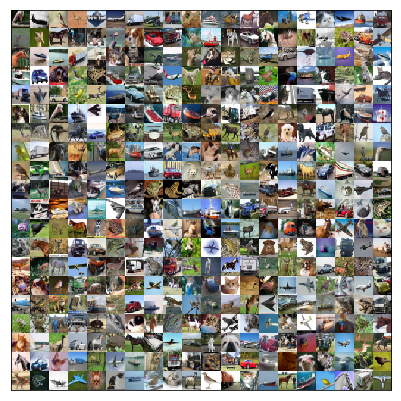

In [ ]:
#function to copy 1 image to larger image map
def copy_image(target , ty, tx, src):
    for y in range(image_size):
        for x in range(image_size):
            target[ty*image_size+y][tx*image_size+x] = src[y][x]
    return target

def copy_image32(target , ty , tx , src):
    for y in range(image_size):
        for x in range(image_size):
            target[ty*image_size+y][tx*image_size+x][0] = src[y][x][0]
            target[ty*image_size+y][tx*image_size+x][1] = src[y][x][1]
            target[ty*image_size+y][tx*image_size+x][2] = src[y][x][2]
            
    return target

print('\n\ndisplaying few training samples')

# show 20 x 20
ysize = 20
xsize = 20
start_offset = 0
base_index = start_offset + (ysize * xsize)

if image_size == 28:
    image = np.zeros((image_size*ysize, image_size*xsize), dtype=np.int)
else:
    image = np.zeros( (image_size*ysize , image_size*xsize , 3), dtype=np.int)

for y in range(ysize):
    for x in range(xsize):
        index = y*xsize + x
        src = x_train[index + base_index]
        if image_size == 28:
            image = copy_image(image , y ,x , src)
        else:
            image = copy_image32( image , y, x, src)

%matplotlib inline
from matplotlib import pyplot as plt

plt.figure(figsize=(7,7))
plt.grid(False)
plt.xticks([])
plt.yticks([])
if image_size == 28:
    plt.imshow(image , cmap='gray_r')
else:
    plt.imshow(image)
plt.show()
plt.close()

In [ ]:
# setup tensorflow dashboard using saved folder
import time
import os

# helper function to create unique sub folder
def create_folder(folder_name):
    if (not os.path.exists(folder_name)):
        os.makedirs(folder_name)
    new_dir = folder_name + "/{}".format(time.time())
    if (not os.path.exists(new_dir)):
        os.makedirs(new_dir)
    return new_dir

log_dir = 'logs'
tf_event_folder = create_folder(log_dir)
tf_callback = tf.keras.callbacks.TensorBoard(log_dir=tf_event_folder)



In [ ]:
# check models
save_folder = 'saved_models'
save_dir = create_folder(save_folder)

checkpt_path=save_dir+'/va{val_acc:.5f}-ep{epoch:04d}-ac{acc:.5f}-vl{val_loss:.5f}-l{loss:.5f}.hdf5'
cp_callback = keras.callbacks.ModelCheckpoint(
  checkpt_path ,
  verbose=1
)

In [ ]:
#model
model = keras.models.Sequential()
model.add( keras.layers.Conv2D(64, kernel_size=(3,3), input_shape=input_shape , activation='relu' , padding='same'))
model.add( keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Dropout(0.2))

model.add( keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Dropout(0.3))

model.add( keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Dropout(0.4))

model.add( keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu' , padding='same'))
model.add( keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add( keras.layers.Dropout(0.5))

model.add( keras.layers.Flatten())
model.add( keras.layers.Dense(512, activation='relu'))
model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Dense(10, activation='softmax'))

# compile to model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 8, 8, 128)         0         
__________

In [ ]:
# data generator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.05,
    horizontal_flip=True
)


In [ ]:
#train the model with train data
import math

fit_history = model.fit_generator(datagen.flow(x_train2, y_train2,
                                    batch_size=batch_size),
                                    steps_per_epoch = math.floor(len(x_train2) / batch_size),
                                    epochs=epochs,
                                    validation_data=(x_test2, y_test2),
                                    workers=4,
                                    callbacks=[tf_callback , cp_callback]
                                 )
'''
fit_history = model.fit(x_train2, y_train2,
  epochs=epochs ,
  batch_size=batch_size,
  validation_data=(x_test2,y_test2)
)
'''


Epoch 1/600


INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 229 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 2.3020 - acc: 0.1014

INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 130s 666ms/step - loss: 2.3019 - acc: 0.1016 - val_loss: 2.3027 - val_acc: 0.1000

Epoch 00001: saving model to saved_models/1556910743.1762419/va0.10000-ep0001-ac0.10164-vl2.30268-l2.30194.hdf5
Epoch 2/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


  1/195 [..............................] - ETA: 37:21 - loss: 2.3068 - acc: 0.0750

INFO:plaidml:Analyzing Ops: 164 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 2.2822 - acc: 0.1153

INFO:plaidml:Analyzing Ops: 101 of 151 operations complete


195/195 [==============================] - 144s 738ms/step - loss: 2.2814 - acc: 0.1159 - val_loss: 2.0837 - val_acc: 0.2328

Epoch 00002: saving model to saved_models/1556910743.1762419/va0.23280-ep0002-ac0.11603-vl2.08366-l2.28127.hdf5
Epoch 3/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


  1/195 [..............................] - ETA: 42:55 - loss: 2.2007 - acc: 0.1172

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 229 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 1.8342 - acc: 0.3057

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 145s 745ms/step - loss: 1.8329 - acc: 0.3062 - val_loss: 1.5278 - val_acc: 0.4256

Epoch 00003: saving model to saved_models/1556910743.1762419/va0.42560-ep0003-ac0.30659-vl1.52781-l1.83208.hdf5
Epoch 4/600


INFO:plaidml:Analyzing Ops: 66 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


  2/195 [..............................] - ETA: 19:53 - loss: 1.6192 - acc: 0.4180

INFO:plaidml:Analyzing Ops: 174 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 141s 723ms/step - loss: 1.5870 - acc: 0.4122 - val_loss: 1.3704 - val_acc: 0.4930

Epoch 00004: saving model to saved_models/1556910743.1762419/va0.49300-ep0004-ac0.41229-vl1.37036-l1.58632.hdf5
Epoch 5/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


  3/195 [..............................] - ETA: 12:38 - loss: 1.4676 - acc: 0.4492

INFO:plaidml:Analyzing Ops: 191 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 141s 721ms/step - loss: 1.4333 - acc: 0.4797 - val_loss: 1.2449 - val_acc: 0.5494

Epoch 00005: saving model to saved_models/1556910743.1762419/va0.54940-ep0005-ac0.47964-vl1.24485-l1.43315.hdf5
Epoch 6/600


INFO:plaidml:Analyzing Ops: 183 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


  4/195 [..............................] - ETA: 10:13 - loss: 1.3680 - acc: 0.4912

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 1.3300 - acc: 0.5200

INFO:plaidml:Analyzing Ops: 84 of 151 operations complete


195/195 [==============================] - 141s 725ms/step - loss: 1.3303 - acc: 0.5200 - val_loss: 1.1987 - val_acc: 0.5678

Epoch 00006: saving model to saved_models/1556910743.1762419/va0.56780-ep0006-ac0.51982-vl1.19870-l1.33057.hdf5
Epoch 7/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


  5/195 [..............................] - ETA: 8:46 - loss: 1.3184 - acc: 0.5359 

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 141s 724ms/step - loss: 1.2339 - acc: 0.5580 - val_loss: 1.1259 - val_acc: 0.5927

Epoch 00007: saving model to saved_models/1556910743.1762419/va0.59270-ep0007-ac0.55792-vl1.12586-l1.23417.hdf5
Epoch 8/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


  6/195 [..............................] - ETA: 7:34 - loss: 1.2147 - acc: 0.5573

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 142s 727ms/step - loss: 1.1788 - acc: 0.5794 - val_loss: 1.0071 - val_acc: 0.6400

Epoch 00008: saving model to saved_models/1556910743.1762419/va0.64000-ep0008-ac0.57975-vl1.00707-l1.17807.hdf5
Epoch 9/600


INFO:plaidml:Analyzing Ops: 123 of 596 operations complete
INFO:plaidml:Analyzing Ops: 227 of 596 operations complete


  7/195 [>.............................] - ETA: 6:38 - loss: 1.0985 - acc: 0.6150

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 143s 733ms/step - loss: 1.1089 - acc: 0.6079 - val_loss: 1.0898 - val_acc: 0.6083

Epoch 00009: saving model to saved_models/1556910743.1762419/va0.60830-ep0009-ac0.60807-vl1.08977-l1.10838.hdf5
Epoch 10/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


  8/195 [>.............................] - ETA: 6:02 - loss: 1.0932 - acc: 0.6099

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 142s 726ms/step - loss: 1.0617 - acc: 0.6233 - val_loss: 0.9986 - val_acc: 0.6480

Epoch 00010: saving model to saved_models/1556910743.1762419/va0.64800-ep0010-ac0.62355-vl0.99855-l1.06186.hdf5
Epoch 11/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


  9/195 [>.............................] - ETA: 5:43 - loss: 1.0780 - acc: 0.6102

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 1.0280 - acc: 0.6361

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 142s 729ms/step - loss: 1.0279 - acc: 0.6364 - val_loss: 0.9235 - val_acc: 0.6741

Epoch 00011: saving model to saved_models/1556910743.1762419/va0.67410-ep0011-ac0.63662-vl0.92347-l1.02710.hdf5
Epoch 12/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 10/195 [>.............................] - ETA: 5:07 - loss: 0.9992 - acc: 0.6543

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 142s 728ms/step - loss: 0.9855 - acc: 0.6574 - val_loss: 0.8705 - val_acc: 0.6943

Epoch 00012: saving model to saved_models/1556910743.1762419/va0.69430-ep0012-ac0.65704-vl0.87047-l0.98544.hdf5
Epoch 13/600


INFO:plaidml:Analyzing Ops: 80 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 11/195 [>.............................] - ETA: 4:48 - loss: 0.9079 - acc: 0.6779

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.9552 - acc: 0.6670

INFO:plaidml:Analyzing Ops: 99 of 151 operations complete


195/195 [==============================] - 141s 723ms/step - loss: 0.9551 - acc: 0.6670 - val_loss: 0.9550 - val_acc: 0.6721

Epoch 00013: saving model to saved_models/1556910743.1762419/va0.67210-ep0013-ac0.66700-vl0.95500-l0.95464.hdf5
Epoch 14/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 12/195 [>.............................] - ETA: 4:30 - loss: 0.9520 - acc: 0.6712

INFO:plaidml:Analyzing Ops: 92 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 141s 725ms/step - loss: 0.9258 - acc: 0.6768 - val_loss: 0.8393 - val_acc: 0.7130

Epoch 00014: saving model to saved_models/1556910743.1762419/va0.71300-ep0014-ac0.67697-vl0.83931-l0.92505.hdf5
Epoch 15/600


INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 13/195 [=>............................] - ETA: 4:16 - loss: 0.9113 - acc: 0.6869

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 143s 732ms/step - loss: 0.8959 - acc: 0.6904 - val_loss: 0.7521 - val_acc: 0.7394

Epoch 00015: saving model to saved_models/1556910743.1762419/va0.73940-ep0015-ac0.69025-vl0.75209-l0.89599.hdf5
Epoch 16/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 14/195 [=>............................] - ETA: 4:05 - loss: 0.9342 - acc: 0.6747

INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.8743 - acc: 0.6960

INFO:plaidml:Analyzing Ops: 103 of 151 operations complete


195/195 [==============================] - 141s 723ms/step - loss: 0.8740 - acc: 0.6961 - val_loss: 0.8484 - val_acc: 0.7130

Epoch 00016: saving model to saved_models/1556910743.1762419/va0.71300-ep0016-ac0.69612-vl0.84839-l0.87401.hdf5
Epoch 17/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 15/195 [=>............................] - ETA: 4:03 - loss: 0.8439 - acc: 0.7018

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.8440 - acc: 0.7067

INFO:plaidml:Analyzing Ops: 82 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 142s 726ms/step - loss: 0.8438 - acc: 0.7067 - val_loss: 0.7929 - val_acc: 0.7277

Epoch 00017: saving model to saved_models/1556910743.1762419/va0.72770-ep0017-ac0.70666-vl0.79288-l0.84352.hdf5
Epoch 18/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 16/195 [=>............................] - ETA: 3:42 - loss: 0.8270 - acc: 0.7158

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.8300 - acc: 0.7120

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 142s 727ms/step - loss: 0.8300 - acc: 0.7120 - val_loss: 0.7845 - val_acc: 0.7281

Epoch 00018: saving model to saved_models/1556910743.1762419/va0.72810-ep0018-ac0.71180-vl0.78455-l0.83065.hdf5
Epoch 19/600


INFO:plaidml:Analyzing Ops: 181 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 17/195 [=>............................] - ETA: 3:37 - loss: 0.8486 - acc: 0.7096

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.8213 - acc: 0.7147

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 143s 731ms/step - loss: 0.8216 - acc: 0.7145 - val_loss: 0.6947 - val_acc: 0.7593

Epoch 00019: saving model to saved_models/1556910743.1762419/va0.75930-ep0019-ac0.71458-vl0.69469-l0.82204.hdf5
Epoch 20/600


INFO:plaidml:Analyzing Ops: 179 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 18/195 [=>............................] - ETA: 3:26 - loss: 0.8271 - acc: 0.7090

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 141s 724ms/step - loss: 0.7932 - acc: 0.7252 - val_loss: 0.7660 - val_acc: 0.7436

Epoch 00020: saving model to saved_models/1556910743.1762419/va0.74360-ep0020-ac0.72539-vl0.76601-l0.79302.hdf5
Epoch 21/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 19/195 [=>............................] - ETA: 3:21 - loss: 0.8018 - acc: 0.7255

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 142s 727ms/step - loss: 0.7755 - acc: 0.7328 - val_loss: 0.7228 - val_acc: 0.7517

Epoch 00021: saving model to saved_models/1556910743.1762419/va0.75170-ep0021-ac0.73303-vl0.72275-l0.77498.hdf5
Epoch 22/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 20/195 [==>...........................] - ETA: 3:12 - loss: 0.7830 - acc: 0.7316

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 141s 721ms/step - loss: 0.7612 - acc: 0.7346 - val_loss: 0.6456 - val_acc: 0.7807

Epoch 00022: saving model to saved_models/1556910743.1762419/va0.78070-ep0022-ac0.73486-vl0.64557-l0.76125.hdf5
Epoch 23/600


INFO:plaidml:Analyzing Ops: 66 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 21/195 [==>...........................] - ETA: 3:08 - loss: 0.7972 - acc: 0.7275

INFO:plaidml:Analyzing Ops: 106 of 596 operations complete
INFO:plaidml:Analyzing Ops: 229 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.7668 - acc: 0.7381

INFO:plaidml:Analyzing Ops: 102 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 142s 728ms/step - loss: 0.7658 - acc: 0.7383 - val_loss: 0.6970 - val_acc: 0.7702

Epoch 00023: saving model to saved_models/1556910743.1762419/va0.77020-ep0023-ac0.73856-vl0.69703-l0.76535.hdf5
Epoch 24/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 22/195 [==>...........................] - ETA: 3:01 - loss: 0.7432 - acc: 0.7449

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 720ms/step - loss: 0.7491 - acc: 0.7407 - val_loss: 0.6637 - val_acc: 0.7717

Epoch 00024: saving model to saved_models/1556910743.1762419/va0.77170-ep0024-ac0.74093-vl0.66367-l0.74912.hdf5
Epoch 25/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 23/195 [==>...........................] - ETA: 2:57 - loss: 0.7234 - acc: 0.7544

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.7296 - acc: 0.7498

INFO:plaidml:Analyzing Ops: 102 of 151 operations complete


195/195 [==============================] - 142s 727ms/step - loss: 0.7299 - acc: 0.7499 - val_loss: 0.6264 - val_acc: 0.7869

Epoch 00025: saving model to saved_models/1556910743.1762419/va0.78690-ep0025-ac0.74978-vl0.62642-l0.72994.hdf5
Epoch 26/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 24/195 [==>...........................] - ETA: 2:50 - loss: 0.7278 - acc: 0.7511

INFO:plaidml:Analyzing Ops: 191 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.7233 - acc: 0.7529

INFO:plaidml:Analyzing Ops: 72 of 150 operations complete


195/195 [==============================] - 140s 718ms/step - loss: 0.7230 - acc: 0.7530 - val_loss: 0.7429 - val_acc: 0.7516

Epoch 00026: saving model to saved_models/1556910743.1762419/va0.75160-ep0026-ac0.75267-vl0.74290-l0.72341.hdf5
Epoch 27/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 25/195 [==>...........................] - ETA: 2:48 - loss: 0.7274 - acc: 0.7533

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.7062 - acc: 0.7583

INFO:plaidml:Analyzing Ops: 82 of 151 operations complete


195/195 [==============================] - 140s 720ms/step - loss: 0.7070 - acc: 0.7580 - val_loss: 0.6601 - val_acc: 0.7751

Epoch 00027: saving model to saved_models/1556910743.1762419/va0.77510-ep0027-ac0.75784-vl0.66012-l0.70784.hdf5
Epoch 28/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 26/195 [===>..........................] - ETA: 2:46 - loss: 0.7151 - acc: 0.7530

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.7079 - acc: 0.7561

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 142s 727ms/step - loss: 0.7079 - acc: 0.7562 - val_loss: 0.6738 - val_acc: 0.7721

Epoch 00028: saving model to saved_models/1556910743.1762419/va0.77210-ep0028-ac0.75621-vl0.67384-l0.70789.hdf5
Epoch 29/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 27/195 [===>..........................] - ETA: 2:40 - loss: 0.6842 - acc: 0.7682

INFO:plaidml:Analyzing Ops: 193 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6883 - acc: 0.7666

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 140s 717ms/step - loss: 0.6880 - acc: 0.7668 - val_loss: 0.6914 - val_acc: 0.7724

Epoch 00029: saving model to saved_models/1556910743.1762419/va0.77240-ep0029-ac0.76681-vl0.69140-l0.68845.hdf5
Epoch 30/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 28/195 [===>..........................] - ETA: 2:40 - loss: 0.7014 - acc: 0.7634

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 141s 722ms/step - loss: 0.6903 - acc: 0.7639 - val_loss: 0.6154 - val_acc: 0.7928

Epoch 00030: saving model to saved_models/1556910743.1762419/va0.79280-ep0030-ac0.76437-vl0.61541-l0.68940.hdf5
Epoch 31/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 229 of 596 operations complete


 29/195 [===>..........................] - ETA: 2:31 - loss: 0.6549 - acc: 0.7746

INFO:plaidml:Analyzing Ops: 193 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6867 - acc: 0.7664

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 72 of 151 operations complete


195/195 [==============================] - 138s 710ms/step - loss: 0.6867 - acc: 0.7664 - val_loss: 0.6432 - val_acc: 0.7831

Epoch 00031: saving model to saved_models/1556910743.1762419/va0.78310-ep0031-ac0.76656-vl0.64323-l0.68570.hdf5
Epoch 32/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 30/195 [===>..........................] - ETA: 2:29 - loss: 0.6816 - acc: 0.7617

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6839 - acc: 0.7649

INFO:plaidml:Analyzing Ops: 74 of 150 operations complete


195/195 [==============================] - 140s 716ms/step - loss: 0.6837 - acc: 0.7650 - val_loss: 0.7102 - val_acc: 0.7642

Epoch 00032: saving model to saved_models/1556910743.1762419/va0.76420-ep0032-ac0.76520-vl0.71021-l0.68343.hdf5
Epoch 33/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 31/195 [===>..........................] - ETA: 2:27 - loss: 0.6678 - acc: 0.7726

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6753 - acc: 0.7725

INFO:plaidml:Analyzing Ops: 83 of 151 operations complete


195/195 [==============================] - 140s 720ms/step - loss: 0.6757 - acc: 0.7725 - val_loss: 0.6043 - val_acc: 0.7957

Epoch 00033: saving model to saved_models/1556910743.1762419/va0.79570-ep0033-ac0.77268-vl0.60433-l0.67482.hdf5
Epoch 34/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 32/195 [===>..........................] - ETA: 2:23 - loss: 0.6459 - acc: 0.7805

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 138s 710ms/step - loss: 0.6511 - acc: 0.7765 - val_loss: 0.6559 - val_acc: 0.7819

Epoch 00034: saving model to saved_models/1556910743.1762419/va0.78190-ep0034-ac0.77642-vl0.65592-l0.65184.hdf5
Epoch 35/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 33/195 [====>.........................] - ETA: 2:21 - loss: 0.6481 - acc: 0.7804

INFO:plaidml:Analyzing Ops: 99 of 596 operations complete
INFO:plaidml:Analyzing Ops: 230 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6470 - acc: 0.7799

INFO:plaidml:Analyzing Ops: 74 of 150 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.6474 - acc: 0.7798 - val_loss: 0.7099 - val_acc: 0.7747

Epoch 00035: saving model to saved_models/1556910743.1762419/va0.77470-ep0035-ac0.77989-vl0.70986-l0.64692.hdf5
Epoch 36/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 34/195 [====>.........................] - ETA: 2:19 - loss: 0.6511 - acc: 0.7801

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6507 - acc: 0.7796

INFO:plaidml:Analyzing Ops: 108 of 151 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.6510 - acc: 0.7794 - val_loss: 0.5906 - val_acc: 0.7986

Epoch 00036: saving model to saved_models/1556910743.1762419/va0.79860-ep0036-ac0.77931-vl0.59064-l0.65086.hdf5
Epoch 37/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 35/195 [====>.........................] - ETA: 2:16 - loss: 0.6553 - acc: 0.7742

INFO:plaidml:Analyzing Ops: 78 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 138s 709ms/step - loss: 0.6481 - acc: 0.7794 - val_loss: 0.6129 - val_acc: 0.7986

Epoch 00037: saving model to saved_models/1556910743.1762419/va0.79860-ep0037-ac0.77941-vl0.61289-l0.64799.hdf5
Epoch 38/600


INFO:plaidml:Analyzing Ops: 97 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 36/195 [====>.........................] - ETA: 2:15 - loss: 0.6515 - acc: 0.7755

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6379 - acc: 0.7828

INFO:plaidml:Analyzing Ops: 116 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 140s 718ms/step - loss: 0.6377 - acc: 0.7827 - val_loss: 0.6177 - val_acc: 0.8005

Epoch 00038: saving model to saved_models/1556910743.1762419/va0.80050-ep0038-ac0.78245-vl0.61765-l0.63798.hdf5
Epoch 39/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 37/195 [====>.........................] - ETA: 2:13 - loss: 0.6404 - acc: 0.7798

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.6342 - acc: 0.7846 - val_loss: 0.6390 - val_acc: 0.7920

Epoch 00039: saving model to saved_models/1556910743.1762419/va0.79200-ep0039-ac0.78448-vl0.63896-l0.63413.hdf5
Epoch 40/600


INFO:plaidml:Analyzing Ops: 112 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 38/195 [====>.........................] - ETA: 2:10 - loss: 0.6429 - acc: 0.7789

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 139s 712ms/step - loss: 0.6249 - acc: 0.7877 - val_loss: 0.5976 - val_acc: 0.8042

Epoch 00040: saving model to saved_models/1556910743.1762419/va0.80420-ep0040-ac0.78777-vl0.59759-l0.62504.hdf5
Epoch 41/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 39/195 [=====>........................] - ETA: 2:09 - loss: 0.6433 - acc: 0.7819

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6291 - acc: 0.7854

INFO:plaidml:Analyzing Ops: 72 of 150 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.6292 - acc: 0.7853 - val_loss: 0.6753 - val_acc: 0.7795

Epoch 00041: saving model to saved_models/1556910743.1762419/va0.77950-ep0041-ac0.78544-vl0.67527-l0.62921.hdf5
Epoch 42/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 40/195 [=====>........................] - ETA: 2:07 - loss: 0.6415 - acc: 0.7818

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.6310 - acc: 0.7879 - val_loss: 0.6391 - val_acc: 0.7789

Epoch 00042: saving model to saved_models/1556910743.1762419/va0.77890-ep0042-ac0.78775-vl0.63913-l0.63106.hdf5
Epoch 43/600


INFO:plaidml:Analyzing Ops: 67 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 41/195 [=====>........................] - ETA: 2:03 - loss: 0.6268 - acc: 0.7891

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 138s 709ms/step - loss: 0.6142 - acc: 0.7913 - val_loss: 0.6275 - val_acc: 0.7859

Epoch 00043: saving model to saved_models/1556910743.1762419/va0.78590-ep0043-ac0.79163-vl0.62749-l0.61386.hdf5
Epoch 44/600


INFO:plaidml:Analyzing Ops: 112 of 596 operations complete
INFO:plaidml:Analyzing Ops: 227 of 596 operations complete


 42/195 [=====>........................] - ETA: 2:02 - loss: 0.6090 - acc: 0.7953

INFO:plaidml:Analyzing Ops: 181 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6105 - acc: 0.7938

INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 141s 721ms/step - loss: 0.6108 - acc: 0.7938 - val_loss: 0.5685 - val_acc: 0.8124

Epoch 00044: saving model to saved_models/1556910743.1762419/va0.81240-ep0044-ac0.79352-vl0.56852-l0.61091.hdf5
Epoch 45/600


INFO:plaidml:Analyzing Ops: 110 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 43/195 [=====>........................] - ETA: 2:04 - loss: 0.5970 - acc: 0.7943

INFO:plaidml:Analyzing Ops: 100 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6085 - acc: 0.7945

INFO:plaidml:Analyzing Ops: 117 of 151 operations complete


195/195 [==============================] - 141s 723ms/step - loss: 0.6088 - acc: 0.7946 - val_loss: 0.5681 - val_acc: 0.8109

Epoch 00045: saving model to saved_models/1556910743.1762419/va0.81090-ep0045-ac0.79489-vl0.56814-l0.60760.hdf5
Epoch 46/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 44/195 [=====>........................] - ETA: 1:58 - loss: 0.5857 - acc: 0.8010

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 138s 709ms/step - loss: 0.5951 - acc: 0.7986 - val_loss: 0.6085 - val_acc: 0.7977

Epoch 00046: saving model to saved_models/1556910743.1762419/va0.79770-ep0046-ac0.79851-vl0.60855-l0.59539.hdf5
Epoch 47/600


INFO:plaidml:Analyzing Ops: 98 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 45/195 [=====>........................] - ETA: 1:58 - loss: 0.6039 - acc: 0.7983

INFO:plaidml:Analyzing Ops: 181 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.6044 - acc: 0.7951

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 140s 720ms/step - loss: 0.6045 - acc: 0.7950 - val_loss: 0.6607 - val_acc: 0.7827

Epoch 00047: saving model to saved_models/1556910743.1762419/va0.78270-ep0047-ac0.79499-vl0.66065-l0.60452.hdf5
Epoch 48/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 46/195 [======>.......................] - ETA: 1:56 - loss: 0.6000 - acc: 0.7959

INFO:plaidml:Analyzing Ops: 174 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.5935 - acc: 0.7986 - val_loss: 0.5498 - val_acc: 0.8091

Epoch 00048: saving model to saved_models/1556910743.1762419/va0.80910-ep0048-ac0.79849-vl0.54985-l0.59355.hdf5
Epoch 49/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 47/195 [======>.......................] - ETA: 1:54 - loss: 0.5942 - acc: 0.7950

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 138s 710ms/step - loss: 0.5944 - acc: 0.7956 - val_loss: 0.6352 - val_acc: 0.7895

Epoch 00049: saving model to saved_models/1556910743.1762419/va0.78950-ep0049-ac0.79523-vl0.63520-l0.59534.hdf5
Epoch 50/600


INFO:plaidml:Analyzing Ops: 91 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 48/195 [======>.......................] - ETA: 1:53 - loss: 0.5921 - acc: 0.7983

INFO:plaidml:Analyzing Ops: 123 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 717ms/step - loss: 0.5831 - acc: 0.8014 - val_loss: 0.5513 - val_acc: 0.8221

Epoch 00050: saving model to saved_models/1556910743.1762419/va0.82210-ep0050-ac0.80132-vl0.55126-l0.58316.hdf5
Epoch 51/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 49/195 [======>.......................] - ETA: 1:51 - loss: 0.5853 - acc: 0.8032

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5805 - acc: 0.8035

INFO:plaidml:Analyzing Ops: 80 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 140s 717ms/step - loss: 0.5807 - acc: 0.8035 - val_loss: 0.6117 - val_acc: 0.7955

Epoch 00051: saving model to saved_models/1556910743.1762419/va0.79550-ep0051-ac0.80341-vl0.61170-l0.58095.hdf5
Epoch 52/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 50/195 [======>.......................] - ETA: 1:51 - loss: 0.5891 - acc: 0.7965

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 139s 714ms/step - loss: 0.5846 - acc: 0.8020 - val_loss: 0.5720 - val_acc: 0.8117

Epoch 00052: saving model to saved_models/1556910743.1762419/va0.81170-ep0052-ac0.80197-vl0.57198-l0.58418.hdf5
Epoch 53/600


INFO:plaidml:Analyzing Ops: 111 of 596 operations complete
INFO:plaidml:Analyzing Ops: 227 of 596 operations complete


 51/195 [======>.......................] - ETA: 1:48 - loss: 0.5938 - acc: 0.7989

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 717ms/step - loss: 0.5854 - acc: 0.8021 - val_loss: 0.5880 - val_acc: 0.8056

Epoch 00053: saving model to saved_models/1556910743.1762419/va0.80560-ep0053-ac0.80223-vl0.58797-l0.58501.hdf5
Epoch 54/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 52/195 [=======>......................] - ETA: 1:47 - loss: 0.5689 - acc: 0.8045

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5769 - acc: 0.8041

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 71 of 151 operations complete


195/195 [==============================] - 140s 718ms/step - loss: 0.5769 - acc: 0.8040 - val_loss: 0.5461 - val_acc: 0.8183

Epoch 00054: saving model to saved_models/1556910743.1762419/va0.81830-ep0054-ac0.80396-vl0.54609-l0.57715.hdf5
Epoch 55/600


INFO:plaidml:Analyzing Ops: 181 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 53/195 [=======>......................] - ETA: 1:45 - loss: 0.5848 - acc: 0.8051

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 138s 708ms/step - loss: 0.5707 - acc: 0.8073 - val_loss: 0.6172 - val_acc: 0.8072

Epoch 00055: saving model to saved_models/1556910743.1762419/va0.80720-ep0055-ac0.80733-vl0.61723-l0.57037.hdf5
Epoch 56/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 54/195 [=======>......................] - ETA: 1:44 - loss: 0.5875 - acc: 0.7985

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 139s 715ms/step - loss: 0.5749 - acc: 0.8058 - val_loss: 0.5569 - val_acc: 0.8132

Epoch 00056: saving model to saved_models/1556910743.1762419/va0.81320-ep0056-ac0.80550-vl0.55690-l0.57553.hdf5
Epoch 57/600


INFO:plaidml:Analyzing Ops: 108 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 55/195 [=======>......................] - ETA: 1:44 - loss: 0.5705 - acc: 0.8065

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5723 - acc: 0.8075

INFO:plaidml:Analyzing Ops: 81 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.5721 - acc: 0.8075 - val_loss: 0.6078 - val_acc: 0.8006

Epoch 00057: saving model to saved_models/1556910743.1762419/va0.80060-ep0057-ac0.80761-vl0.60779-l0.57184.hdf5
Epoch 58/600


INFO:plaidml:Analyzing Ops: 182 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 56/195 [=======>......................] - ETA: 1:41 - loss: 0.5525 - acc: 0.8153

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 138s 709ms/step - loss: 0.5602 - acc: 0.8125 - val_loss: 0.5646 - val_acc: 0.8093

Epoch 00058: saving model to saved_models/1556910743.1762419/va0.80930-ep0058-ac0.81272-vl0.56456-l0.56003.hdf5
Epoch 59/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 57/195 [=======>......................] - ETA: 1:41 - loss: 0.5850 - acc: 0.8047

INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5723 - acc: 0.8059

INFO:plaidml:Analyzing Ops: 72 of 150 operations complete


195/195 [==============================] - 140s 719ms/step - loss: 0.5721 - acc: 0.8059 - val_loss: 0.5664 - val_acc: 0.8140

Epoch 00059: saving model to saved_models/1556910743.1762419/va0.81400-ep0059-ac0.80599-vl0.56638-l0.57207.hdf5
Epoch 60/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 58/195 [=======>......................] - ETA: 1:41 - loss: 0.5635 - acc: 0.8094

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5599 - acc: 0.8116

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 74 of 151 operations complete


195/195 [==============================] - 141s 721ms/step - loss: 0.5598 - acc: 0.8116 - val_loss: 0.5507 - val_acc: 0.8207

Epoch 00060: saving model to saved_models/1556910743.1762419/va0.82070-ep0060-ac0.81151-vl0.55073-l0.55943.hdf5
Epoch 61/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 59/195 [========>.....................] - ETA: 1:37 - loss: 0.5694 - acc: 0.8118

INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 138s 709ms/step - loss: 0.5597 - acc: 0.8129 - val_loss: 0.5625 - val_acc: 0.8137

Epoch 00061: saving model to saved_models/1556910743.1762419/va0.81370-ep0061-ac0.81296-vl0.56252-l0.55922.hdf5
Epoch 62/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 60/195 [========>.....................] - ETA: 1:38 - loss: 0.5540 - acc: 0.8110

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 140s 720ms/step - loss: 0.5502 - acc: 0.8133 - val_loss: 0.5494 - val_acc: 0.8221

Epoch 00062: saving model to saved_models/1556910743.1762419/va0.82210-ep0062-ac0.81316-vl0.54944-l0.55044.hdf5
Epoch 63/600


INFO:plaidml:Analyzing Ops: 106 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 61/195 [========>.....................] - ETA: 1:37 - loss: 0.5660 - acc: 0.8069

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5596 - acc: 0.8125

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 148s 760ms/step - loss: 0.5593 - acc: 0.8126 - val_loss: 0.6355 - val_acc: 0.7972

Epoch 00063: saving model to saved_models/1556910743.1762419/va0.79720-ep0063-ac0.81234-vl0.63554-l0.55977.hdf5
Epoch 64/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 62/195 [========>.....................] - ETA: 1:39 - loss: 0.5456 - acc: 0.8160

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5512 - acc: 0.8130

INFO:plaidml:Analyzing Ops: 89 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 145s 745ms/step - loss: 0.5507 - acc: 0.8131 - val_loss: 0.5513 - val_acc: 0.8170

Epoch 00064: saving model to saved_models/1556910743.1762419/va0.81700-ep0064-ac0.81310-vl0.55126-l0.55034.hdf5
Epoch 65/600


INFO:plaidml:Analyzing Ops: 177 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 63/195 [========>.....................] - ETA: 1:38 - loss: 0.5613 - acc: 0.8119

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5507 - acc: 0.8150 - val_loss: 0.5182 - val_acc: 0.8258

Epoch 00065: saving model to saved_models/1556910743.1762419/va0.82580-ep0065-ac0.81521-vl0.51821-l0.54994.hdf5
Epoch 66/600


INFO:plaidml:Analyzing Ops: 106 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 64/195 [========>.....................] - ETA: 1:40 - loss: 0.5549 - acc: 0.8138

INFO:plaidml:Analyzing Ops: 79 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5480 - acc: 0.8151

INFO:plaidml:Analyzing Ops: 143 of 151 operations complete


195/195 [==============================] - 150s 769ms/step - loss: 0.5479 - acc: 0.8151 - val_loss: 0.5379 - val_acc: 0.8244

Epoch 00066: saving model to saved_models/1556910743.1762419/va0.82440-ep0066-ac0.81535-vl0.53786-l0.54765.hdf5
Epoch 67/600


INFO:plaidml:Analyzing Ops: 69 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 65/195 [=========>....................] - ETA: 1:35 - loss: 0.5508 - acc: 0.8145

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5487 - acc: 0.8144

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5484 - acc: 0.8145 - val_loss: 0.4938 - val_acc: 0.8359

Epoch 00067: saving model to saved_models/1556910743.1762419/va0.83590-ep0067-ac0.81455-vl0.49375-l0.54877.hdf5
Epoch 68/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 66/195 [=========>....................] - ETA: 1:35 - loss: 0.5545 - acc: 0.8149

INFO:plaidml:Analyzing Ops: 193 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5441 - acc: 0.8164

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 75 of 151 operations complete


195/195 [==============================] - 146s 747ms/step - loss: 0.5442 - acc: 0.8165 - val_loss: 0.5699 - val_acc: 0.8122

Epoch 00068: saving model to saved_models/1556910743.1762419/va0.81220-ep0068-ac0.81642-vl0.56985-l0.54436.hdf5
Epoch 69/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 67/195 [=========>....................] - ETA: 1:36 - loss: 0.5455 - acc: 0.8136

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5402 - acc: 0.8179

INFO:plaidml:Analyzing Ops: 83 of 150 operations complete
INFO:plaidml:Analyzing Ops: 73 of 151 operations complete


195/195 [==============================] - 150s 767ms/step - loss: 0.5400 - acc: 0.8179 - val_loss: 0.5554 - val_acc: 0.8225

Epoch 00069: saving model to saved_models/1556910743.1762419/va0.82250-ep0069-ac0.81797-vl0.55537-l0.53905.hdf5
Epoch 70/600


INFO:plaidml:Analyzing Ops: 176 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 68/195 [=========>....................] - ETA: 1:32 - loss: 0.5451 - acc: 0.8142

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 145s 745ms/step - loss: 0.5397 - acc: 0.8167 - val_loss: 0.5414 - val_acc: 0.8229

Epoch 00070: saving model to saved_models/1556910743.1762419/va0.82290-ep0070-ac0.81654-vl0.54138-l0.54020.hdf5
Epoch 71/600


INFO:plaidml:Analyzing Ops: 75 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 69/195 [=========>....................] - ETA: 1:31 - loss: 0.5342 - acc: 0.8207

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5395 - acc: 0.8178

INFO:plaidml:Analyzing Ops: 76 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 146s 751ms/step - loss: 0.5396 - acc: 0.8177 - val_loss: 0.5654 - val_acc: 0.8203

Epoch 00071: saving model to saved_models/1556910743.1762419/va0.82030-ep0071-ac0.81767-vl0.56541-l0.53967.hdf5
Epoch 72/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 215 of 596 operations complete


 70/195 [=========>....................] - ETA: 1:35 - loss: 0.5410 - acc: 0.8160

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5341 - acc: 0.8201

INFO:plaidml:Analyzing Ops: 95 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 151s 775ms/step - loss: 0.5339 - acc: 0.8202 - val_loss: 0.5678 - val_acc: 0.8091

Epoch 00072: saving model to saved_models/1556910743.1762419/va0.80910-ep0072-ac0.82016-vl0.56781-l0.53385.hdf5
Epoch 73/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 71/195 [=========>....................] - ETA: 1:29 - loss: 0.5401 - acc: 0.8201

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 745ms/step - loss: 0.5417 - acc: 0.8177 - val_loss: 0.5572 - val_acc: 0.8164

Epoch 00073: saving model to saved_models/1556910743.1762419/va0.81640-ep0073-ac0.81734-vl0.55715-l0.54238.hdf5
Epoch 74/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 72/195 [==========>...................] - ETA: 1:28 - loss: 0.5414 - acc: 0.8223

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5375 - acc: 0.8215

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5382 - acc: 0.8213 - val_loss: 0.5362 - val_acc: 0.8222

Epoch 00074: saving model to saved_models/1556910743.1762419/va0.82220-ep0074-ac0.82131-vl0.53618-l0.53813.hdf5
Epoch 75/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 73/195 [==========>...................] - ETA: 1:30 - loss: 0.5355 - acc: 0.8190

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5403 - acc: 0.8183

INFO:plaidml:Analyzing Ops: 102 of 150 operations complete
INFO:plaidml:Analyzing Ops: 84 of 151 operations complete


195/195 [==============================] - 149s 766ms/step - loss: 0.5404 - acc: 0.8184 - val_loss: 0.5249 - val_acc: 0.8238

Epoch 00075: saving model to saved_models/1556910743.1762419/va0.82380-ep0075-ac0.81833-vl0.52490-l0.54055.hdf5
Epoch 76/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 74/195 [==========>...................] - ETA: 1:26 - loss: 0.5311 - acc: 0.8238

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5346 - acc: 0.8231 - val_loss: 0.5330 - val_acc: 0.8212

Epoch 00076: saving model to saved_models/1556910743.1762419/va0.82120-ep0076-ac0.82309-vl0.53299-l0.53451.hdf5
Epoch 77/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 75/195 [==========>...................] - ETA: 1:25 - loss: 0.5324 - acc: 0.8211

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5254 - acc: 0.8242 - val_loss: 0.5028 - val_acc: 0.8347

Epoch 00077: saving model to saved_models/1556910743.1762419/va0.83470-ep0077-ac0.82402-vl0.50284-l0.52585.hdf5
Epoch 78/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 76/195 [==========>...................] - ETA: 1:27 - loss: 0.5221 - acc: 0.8270

INFO:plaidml:Analyzing Ops: 112 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 149s 766ms/step - loss: 0.5216 - acc: 0.8267 - val_loss: 0.5398 - val_acc: 0.8248

Epoch 00078: saving model to saved_models/1556910743.1762419/va0.82480-ep0078-ac0.82687-vl0.53984-l0.52095.hdf5
Epoch 79/600


INFO:plaidml:Analyzing Ops: 101 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 77/195 [==========>...................] - ETA: 1:24 - loss: 0.5266 - acc: 0.8233

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.8223

INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5308 - acc: 0.8225 - val_loss: 0.5119 - val_acc: 0.8300

Epoch 00079: saving model to saved_models/1556910743.1762419/va0.83000-ep0079-ac0.82251-vl0.51187-l0.53091.hdf5
Epoch 80/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 78/195 [===========>..................] - ETA: 1:23 - loss: 0.5150 - acc: 0.8239

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5169 - acc: 0.8239

INFO:plaidml:Analyzing Ops: 76 of 150 operations complete


195/195 [==============================] - 145s 743ms/step - loss: 0.5166 - acc: 0.8239 - val_loss: 0.5667 - val_acc: 0.8174

Epoch 00080: saving model to saved_models/1556910743.1762419/va0.81740-ep0080-ac0.82356-vl0.56667-l0.51748.hdf5
Epoch 81/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 79/195 [===========>..................] - ETA: 1:24 - loss: 0.5210 - acc: 0.8257

INFO:plaidml:Analyzing Ops: 192 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 150s 768ms/step - loss: 0.5198 - acc: 0.8266 - val_loss: 0.5515 - val_acc: 0.8211

Epoch 00081: saving model to saved_models/1556910743.1762419/va0.82110-ep0081-ac0.82663-vl0.55146-l0.51983.hdf5
Epoch 82/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 80/195 [===========>..................] - ETA: 1:20 - loss: 0.5079 - acc: 0.8261

INFO:plaidml:Analyzing Ops: 94 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 145s 743ms/step - loss: 0.5146 - acc: 0.8254 - val_loss: 0.5586 - val_acc: 0.8177

Epoch 00082: saving model to saved_models/1556910743.1762419/va0.81770-ep0082-ac0.82545-vl0.55863-l0.51415.hdf5
Epoch 83/600


INFO:plaidml:Analyzing Ops: 108 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 81/195 [===========>..................] - ETA: 1:20 - loss: 0.5105 - acc: 0.8270

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 742ms/step - loss: 0.5152 - acc: 0.8255 - val_loss: 0.5126 - val_acc: 0.8305

Epoch 00083: saving model to saved_models/1556910743.1762419/va0.83050-ep0083-ac0.82551-vl0.51259-l0.51540.hdf5
Epoch 84/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 82/195 [===========>..................] - ETA: 1:21 - loss: 0.5157 - acc: 0.8246

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 149s 766ms/step - loss: 0.5103 - acc: 0.8280 - val_loss: 0.4537 - val_acc: 0.8477

Epoch 00084: saving model to saved_models/1556910743.1762419/va0.84770-ep0084-ac0.82816-vl0.45365-l0.51001.hdf5
Epoch 85/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 83/195 [===========>..................] - ETA: 1:18 - loss: 0.5103 - acc: 0.8292

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 743ms/step - loss: 0.5118 - acc: 0.8277 - val_loss: 0.5426 - val_acc: 0.8267

Epoch 00085: saving model to saved_models/1556910743.1762419/va0.82670-ep0085-ac0.82796-vl0.54262-l0.51127.hdf5
Epoch 86/600


INFO:plaidml:Analyzing Ops: 98 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 84/195 [===========>..................] - ETA: 1:17 - loss: 0.5170 - acc: 0.8274

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5137 - acc: 0.8281

INFO:plaidml:Analyzing Ops: 93 of 151 operations complete


195/195 [==============================] - 145s 743ms/step - loss: 0.5140 - acc: 0.8281 - val_loss: 0.4642 - val_acc: 0.8469

Epoch 00086: saving model to saved_models/1556910743.1762419/va0.84690-ep0086-ac0.82798-vl0.46422-l0.51399.hdf5
Epoch 87/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 85/195 [============>.................] - ETA: 1:19 - loss: 0.5153 - acc: 0.8271

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5087 - acc: 0.8298

INFO:plaidml:Analyzing Ops: 98 of 150 operations complete
INFO:plaidml:Analyzing Ops: 81 of 151 operations complete


195/195 [==============================] - 150s 768ms/step - loss: 0.5090 - acc: 0.8298 - val_loss: 0.4882 - val_acc: 0.8388

Epoch 00087: saving model to saved_models/1556910743.1762419/va0.83880-ep0087-ac0.82949-vl0.48820-l0.50962.hdf5
Epoch 88/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 86/195 [============>.................] - ETA: 1:15 - loss: 0.5001 - acc: 0.8329

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5042 - acc: 0.8331 - val_loss: 0.5177 - val_acc: 0.8251

Epoch 00088: saving model to saved_models/1556910743.1762419/va0.82510-ep0088-ac0.83296-vl0.51769-l0.50436.hdf5
Epoch 89/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 87/195 [============>.................] - ETA: 1:15 - loss: 0.5109 - acc: 0.8302

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 145s 744ms/step - loss: 0.5044 - acc: 0.8330 - val_loss: 0.4591 - val_acc: 0.8467

Epoch 00089: saving model to saved_models/1556910743.1762419/va0.84670-ep0089-ac0.83286-vl0.45913-l0.50476.hdf5
Epoch 90/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 88/195 [============>.................] - ETA: 1:16 - loss: 0.5106 - acc: 0.8271

INFO:plaidml:Analyzing Ops: 195 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5088 - acc: 0.8285

INFO:plaidml:Analyzing Ops: 137 of 150 operations complete
INFO:plaidml:Analyzing Ops: 89 of 151 operations complete


195/195 [==============================] - 150s 768ms/step - loss: 0.5094 - acc: 0.8285 - val_loss: 0.4871 - val_acc: 0.8394

Epoch 00090: saving model to saved_models/1556910743.1762419/va0.83940-ep0090-ac0.82860-vl0.48713-l0.50859.hdf5
Epoch 91/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 89/195 [============>.................] - ETA: 1:13 - loss: 0.5226 - acc: 0.8270

INFO:plaidml:Analyzing Ops: 183 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5087 - acc: 0.8297

INFO:plaidml:Analyzing Ops: 73 of 150 operations complete


195/195 [==============================] - 148s 759ms/step - loss: 0.5084 - acc: 0.8298 - val_loss: 0.5269 - val_acc: 0.8306

Epoch 00091: saving model to saved_models/1556910743.1762419/va0.83060-ep0091-ac0.82989-vl0.52691-l0.50805.hdf5
Epoch 92/600


INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 229 of 596 operations complete


 90/195 [============>.................] - ETA: 1:15 - loss: 0.4977 - acc: 0.8327

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 150s 770ms/step - loss: 0.4974 - acc: 0.8337 - val_loss: 0.5109 - val_acc: 0.8315

Epoch 00092: saving model to saved_models/1556910743.1762419/va0.83150-ep0092-ac0.83375-vl0.51093-l0.49736.hdf5
Epoch 93/600


INFO:plaidml:Analyzing Ops: 66 of 596 operations complete
INFO:plaidml:Analyzing Ops: 219 of 596 operations complete


 91/195 [=============>................] - ETA: 1:14 - loss: 0.5160 - acc: 0.8299

INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5093 - acc: 0.8315

INFO:plaidml:Analyzing Ops: 117 of 150 operations complete
INFO:plaidml:Analyzing Ops: 90 of 151 operations complete


195/195 [==============================] - 150s 768ms/step - loss: 0.5088 - acc: 0.8317 - val_loss: 0.5858 - val_acc: 0.8165

Epoch 00093: saving model to saved_models/1556910743.1762419/va0.81650-ep0093-ac0.83194-vl0.58578-l0.50833.hdf5
Epoch 94/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 92/195 [=============>................] - ETA: 1:13 - loss: 0.5246 - acc: 0.8251

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5201 - acc: 0.8261

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete


195/195 [==============================] - 150s 769ms/step - loss: 0.5198 - acc: 0.8263 - val_loss: 0.5117 - val_acc: 0.8323

Epoch 00094: saving model to saved_models/1556910743.1762419/va0.83230-ep0094-ac0.82633-vl0.51171-l0.51964.hdf5
Epoch 95/600


INFO:plaidml:Analyzing Ops: 179 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 93/195 [=============>................] - ETA: 1:12 - loss: 0.4996 - acc: 0.8312

INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.4963 - acc: 0.8329

INFO:plaidml:Analyzing Ops: 79 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 150s 767ms/step - loss: 0.4969 - acc: 0.8327 - val_loss: 0.5152 - val_acc: 0.8361

Epoch 00095: saving model to saved_models/1556910743.1762419/va0.83610-ep0095-ac0.83276-vl0.51515-l0.49708.hdf5
Epoch 96/600


INFO:plaidml:Analyzing Ops: 189 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 94/195 [=============>................] - ETA: 1:11 - loss: 0.5017 - acc: 0.8303

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 149s 765ms/step - loss: 0.4961 - acc: 0.8331 - val_loss: 0.4910 - val_acc: 0.8407

Epoch 00096: saving model to saved_models/1556910743.1762419/va0.84070-ep0096-ac0.83298-vl0.49097-l0.49646.hdf5
Epoch 97/600


INFO:plaidml:Analyzing Ops: 105 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 95/195 [=============>................] - ETA: 1:11 - loss: 0.5110 - acc: 0.8309

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


194/195 [============================>.] - ETA: 0s - loss: 0.5024 - acc: 0.8329

INFO:plaidml:Analyzing Ops: 107 of 150 operations complete
INFO:plaidml:Analyzing Ops: 80 of 151 operations complete


195/195 [==============================] - 151s 775ms/step - loss: 0.5023 - acc: 0.8330 - val_loss: 0.4778 - val_acc: 0.8467

Epoch 00097: saving model to saved_models/1556910743.1762419/va0.84670-ep0097-ac0.83309-vl0.47776-l0.50202.hdf5
Epoch 98/600


INFO:plaidml:Analyzing Ops: 179 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


 96/195 [=============>................] - ETA: 1:10 - loss: 0.4973 - acc: 0.8376

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 150s 771ms/step - loss: 0.4955 - acc: 0.8357 - val_loss: 0.4911 - val_acc: 0.8428

Epoch 00098: saving model to saved_models/1556910743.1762419/va0.84280-ep0098-ac0.83568-vl0.49112-l0.49561.hdf5
Epoch 99/600


INFO:plaidml:Analyzing Ops: 70 of 596 operations complete
INFO:plaidml:Analyzing Ops: 217 of 596 operations complete


 97/195 [=============>................] - ETA: 1:09 - loss: 0.4777 - acc: 0.8402

INFO:plaidml:Analyzing Ops: 171 of 596 operations complete
INFO:plaidml:Analyzing Ops: 231 of 596 operations complete


195/195 [==============================] - 150s 767ms/step - loss: 0.4881 - acc: 0.8374 - val_loss: 0.5369 - val_acc: 0.8284

Epoch 00099: saving model to saved_models/1556910743.1762419/va0.82840-ep0099-ac0.83717-vl0.53688-l0.48873.hdf5
Epoch 100/600


INFO:plaidml:Analyzing Ops: 77 of 596 operations complete
INFO:plaidml:Analyzing Ops: 225 of 596 operations complete


 52/195 [=======>......................] - ETA: 1:57 - loss: 0.4966 - acc: 0.8344

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt

# show procession of training...
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(fit_history.history['acc'])
plt.plot(fit_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
plt.close()